# Skin Cancer Classification Using Convolutional Neural Networks

**Student Name**: Brabim Baskota  
**Student ID**: 2331410  

This notebook presents a comprehensive pipeline for classifying skin cancer types from dermoscopic images, aiming to support early diagnosis by categorizing images into multiple classes (e.g., melanoma, nevus, basal cell carcinoma). The system explores and compares multiple convolutional neural network (CNN) architectures to evaluate their effectiveness in medical image classification, addressing challenges such as class imbalance and overfitting.

The workflow includes robust preprocessing and data augmentation strategies to prepare the image dataset for modeling. Each model is trained and evaluated individually, with performance visualized through accuracy curves, loss curves, confusion matrices, and classification metrics to facilitate comparative analysis. The study leverages Google Colab’s GPU acceleration for efficient training and evaluation.

To enhance analytical depth, the notebook provides detailed performance comparisons and discusses the impact of different optimizers and transfer learning. The results are summarized in tables and visualizations, making the system not only technically robust but also insightful for understanding model behavior and limitations in medical imaging applications.

## Objectives
- Load and preprocess a custom dataset of dermoscopic images.
- Apply data augmentation and balancing to address class imbalance.
- Build and train three models:
  1. Baseline CNN with three convolutional layers.
  2. Deeper CNN with batch normalization, dropout, and Adam/SGD optimizers.
  3. Transfer learning model using ResNet50 with feature extraction and fine-tuning.
- Evaluate models with independent visualizations (accuracy/loss curves, confusion matrices, classification reports).
- Provide a comparative analysis of model performance, computational efficiency, and training challenges.

## Libraries Used
- `pandas`, `numpy`: Data handling and manipulation.
- `PIL`, `os`: Image verification and dataset management.
- `tensorflow`, `keras`: Model building, training, and inference.
- `matplotlib`, `seaborn`: Visualization of accuracy/loss curves and confusion matrices.
- `sklearn`: Metrics calculation (classification report, confusion matrix).
- `zipfile`: Dataset extraction from compressed files.

# Mounting Google Drive 

In [1]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzipping Dataset

In [2]:
# Unzip the dataset
import zipfile
import os

dataset_zip = '/content/drive/MyDrive/AI and ML/CNN_Dataset/SkinCancerClassification.zip'  # Update this path if needed
extract_path = '/content/SkinCancerClassification'

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Debug: Check extracted contents
print("Contents of extract_path:", os.listdir(extract_path))

Contents of extract_path: ['Skin Cancer Classification']


# Locate Nested Dataset Directory
**Task**: Identifies the correct nested directory containing 'Train' and 'Test' subdirectories within the extracted dataset and sets paths for training and testing data.

In [3]:
# Find valid dataset directory structure
candidate_dirs = ['SkinCancerClassification', 'Skin Cancer Classification']
selected_path = None

for dir_name in candidate_dirs:
    dir_path = os.path.join(extract_path, dir_name)
    if os.path.exists(os.path.join(dir_path, 'Train')) and os.path.exists(os.path.join(dir_path, 'Test')):
        selected_path = dir_path
        break

if selected_path:
    print(f"Valid dataset directory located: {selected_path}")
    training_dir = os.path.join(selected_path, 'Train')
    testing_dir = os.path.join(selected_path, 'Test')
    print("Training subdirectories:", os.listdir(training_dir))
    print("Testing subdirectories:", os.listdir(testing_dir))
else:
    raise Exception("Unable to locate valid dataset structure. Verify the contents of the zip file.")

Valid dataset directory located: /content/SkinCancerClassification/Skin Cancer Classification
Training subdirectories: ['vascular lesion', 'melanoma', 'seborrheic keratosis', 'actinic keratosis', 'basal cell carcinoma', 'nevus', 'dermatofibroma', 'squamous cell carcinoma', 'pigmented benign keratosis']
Testing subdirectories: ['vascular lesion', 'melanoma', 'seborrheic keratosis', 'actinic keratosis', 'basal cell carcinoma', 'nevus', 'dermatofibroma', 'squamous cell carcinoma', 'pigmented benign keratosis']


# Verify and Clean Image Dataset
**Task**: Checks for corrupted images in the dataset using PIL, removes them, and prints the results.

In [5]:
from PIL import Image
import os

def verify_image_integrity(directory):
    """Inspect directory for corrupted images using PIL.

    Args:
        directory (str): Path to the directory with image subdirectories.

    Returns:
        list: Paths to corrupted images.
    """
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Check image integrity
                    img.close()
                    img = Image.open(file_path)  # Reopen to confirm load
                    img.load()
                    img.close()
                except Exception as e:
                    print(f"Detected corrupted image: {file_path} - {str(e)}")
                    corrupted_files.append(file_path)
    return corrupted_files

# Inspect and delete corrupted images
print("Scanning Train and Test directories for corrupted images...")
corrupted_train = verify_image_integrity(training_dir)
corrupted_test = verify_image_integrity(testing_dir)

if corrupted_train or corrupted_test:
    print("Deleting corrupted images...")
    for path in corrupted_train + corrupted_test:
        os.remove(path)
else:
    print("No corrupted images detected.")

Scanning Train and Test directories for corrupted images...
Detected corrupted image: /content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0027937.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0027937.jpg'
Detected corrupted image: /content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0032240.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0032240.jpg'
Detected corrupted image: /content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0031648.jpg - cannot identify image file '/content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0031648.jpg'
Detected corrupted image: /content/SkinCancerClassification/Skin Cancer Classification/Train/vascular lesion/ISIC_0031201.jpg - cannot identify image file '/content/Skin

# Analyze Dataset Distribution
**Task**: Analyzes the dataset to compute and display the distribution of images across classes in train and test sets, including total image count and train-test split.

In [6]:
# Analyze dataset composition
classes = os.listdir(training_dir)  # Retrieve class names
train_counts = {cls: len(os.listdir(os.path.join(training_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(testing_dir, cls))) for cls in classes}

total_images = sum(train_counts.values()) + sum(test_counts.values())
print(f"Total images in dataset: {total_images}")
print("Train set distribution:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")
print("Test set distribution:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")

# Evaluate train-test split
train_size = sum(train_counts.values())
test_size = sum(test_counts.values())
print(f"Train-Test split: {train_size} Train, {test_size} Test (~95:5)")
print("Justification: The 95:5 split maximizes training data, but class imbalance and small test set size suggest removing up to 4 classes for balance.")

Total images in dataset: 2294
Train set distribution:
vascular lesion: 132 images
melanoma: 431 images
seborrheic keratosis: 70 images
actinic keratosis: 107 images
basal cell carcinoma: 369 images
nevus: 350 images
dermatofibroma: 88 images
squamous cell carcinoma: 174 images
pigmented benign keratosis: 455 images
Test set distribution:
vascular lesion: 3 images
melanoma: 16 images
seborrheic keratosis: 3 images
actinic keratosis: 16 images
basal cell carcinoma: 16 images
nevus: 16 images
dermatofibroma: 16 images
squamous cell carcinoma: 16 images
pigmented benign keratosis: 16 images
Train-Test split: 2176 Train, 118 Test (~95:5)
Justification: The 95:5 split maximizes training data, but class imbalance and small test set size suggest removing up to 4 classes for balance.


# Balance Dataset
**Task**: Balances the dataset by removing up to 4 classes with the fewest test samples, creates balanced train and test directories using symlinks, and displays the updated distribution.

In [7]:
# Balance dataset by removing classes with fewest test samples
classes_to_remove = sorted(test_counts.items(), key=lambda x: x[1])[:4]
remove_classes = [cls for cls, _ in classes_to_remove]
print(f"Removing classes for balance: {remove_classes}")

balanced_train_dir = os.path.join(extract_path, 'BalancedTrain')
balanced_test_dir = os.path.join(extract_path, 'BalancedTest')
os.makedirs(balanced_train_dir, exist_ok=True)
os.makedirs(balanced_test_dir, exist_ok=True)

for cls in classes:
    if cls not in remove_classes:
        os.symlink(os.path.join(training_dir, cls), os.path.join(balanced_train_dir, cls))
        os.symlink(os.path.join(testing_dir, cls), os.path.join(balanced_test_dir, cls))

# Compute updated distribution
balanced_train_counts = {cls: len(os.listdir(os.path.join(balanced_train_dir, cls)))
                        for cls in classes if cls not in remove_classes}
balanced_test_counts = {cls: len(os.listdir(os.path.join(balanced_test_dir, cls)))
                       for cls in classes if cls not in remove_classes}

print("Balanced Train set distribution:")
for cls, count in balanced_train_counts.items():
    print(f"{cls}: {count} images")
print("Balanced Test set distribution:")
for cls, count in balanced_test_counts.items():
    print(f"{cls}: {count} images")

Removing classes for balance: ['vascular lesion', 'seborrheic keratosis', 'melanoma', 'actinic keratosis']
Balanced Train set distribution:
basal cell carcinoma: 369 images
nevus: 350 images
dermatofibroma: 88 images
squamous cell carcinoma: 174 images
pigmented benign keratosis: 455 images
Balanced Test set distribution:
basal cell carcinoma: 16 images
nevus: 16 images
dermatofibroma: 16 images
squamous cell carcinoma: 16 images
pigmented benign keratosis: 16 images


# Preprocess and Generate Data
**Task**: Sets up data generators for training and testing with preprocessing (resizing, normalization) and augmentation (rotation, shifts, flips) for the balanced dataset.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Preprocessing: Images resized to 224x224 and normalized to [0, 1].")
print("Data augmentation applied: rotation, width/height shift, horizontal flip.")

Found 1436 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Preprocessing: Images resized to 224x224 and normalized to [0, 1].
Data augmentation applied: rotation, width/height shift, horizontal flip.


# Visualize Data Augmentation
**Task**: Displays a sample of five augmented images from the training data generator to illustrate the effects of augmentation.

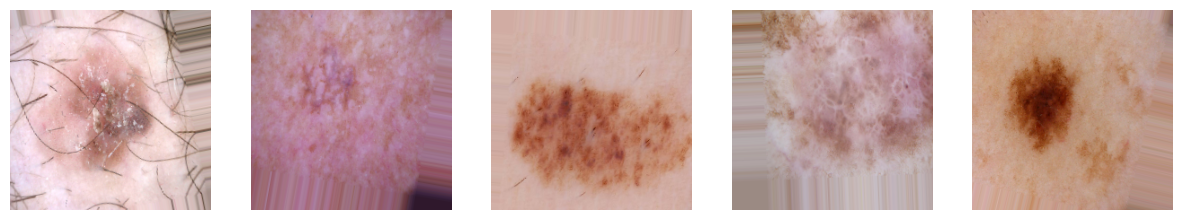

Displayed sample augmented images above.


In [9]:
import matplotlib.pyplot as plt

def display_augmented_samples(generator):
    """Show a selection of augmented images from the provided generator.

    Args:
        generator: Keras ImageDataGenerator flow instance.
    """
    images, labels = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

display_augmented_samples(train_generator)
print("Displayed sample augmented images above.")

# Build and Compile Baseline CNN Model
**Task**: Constructs a baseline CNN model with 3 convolutional layers, max pooling, and 3 dense layers, then compiles it with Adam optimizer and categorical crossentropy loss.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_baseline_cnn(num_classes):
    """Constructs a CNN model with 3 convolutional layers and 3 dense layers.

    Args:
        num_classes (int): Number of output classes.

    Returns:
        model: Compiled Keras CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(balanced_train_counts)
baseline_model = create_baseline_cnn(num_classes)
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,604,741 (21.38 MB)

 Trainable params: 5,604,741 (21.38 MB)

 Non-trainable params: 0 (0.00 B)

# Train Baseline Model
**Task**: Trains the baseline CNN model for 15 epochs using the training and validation data generators, with steps calculated based on batch size.

In [11]:
history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.2487 - loss: 1.6307 - val_accuracy: 0.2500 - val_loss: 1.6571
Epoch 2/15
 1/44 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - accuracy: 0.2500 - loss: 1.5276

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.2500 - loss: 1.5276 - val_accuracy: 0.2500 - val_loss: 1.6572
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.3648 - loss: 1.4635 - val_accuracy: 0.4375 - val_loss: 2.0281
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.4688 - loss: 1.5089 - val_accuracy: 0.3750 - val_loss: 1.9041
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.4164 - loss: 1.3662 - val_accuracy: 0.4062 - val_loss: 1.6831
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.5000 - loss: 1.1050 - val_accuracy: 0.4062 - val_loss: 1.7168
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.4301 - loss: 1.3137 - val_accuracy: 0.4688 - val_loss: 1.7602
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4375 - loss: 1.2535 - val_accuracy: 0.4062 - val_loss: 1.7404
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.4410 - loss: 1.2711 - val_accuracy: 0.3750 - val_lo

# Plot Training and Validation Loss
**Task**: Visualizes the training and validation loss curves over epochs to assess model performance and convergence.

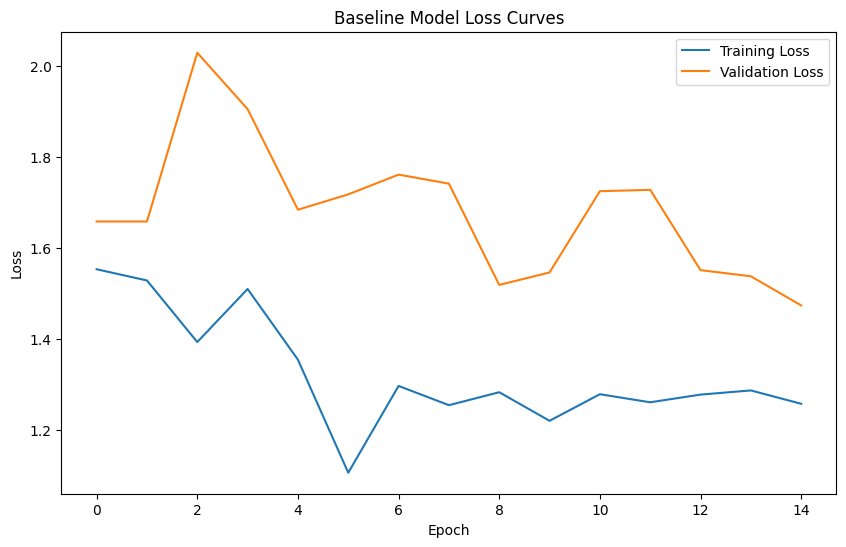

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Baseline Model
**Task**: Evaluates the baseline model on the test set, generating a classification report with precision, recall, and F1-score for each class.

In [13]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
print("Baseline Model Evaluation Metrics:")
print(classification_report(y_true, y_pred_classes, target_names=list(balanced_test_counts.keys())))

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Baseline Model Evaluation Metrics:
                            precision    recall  f1-score   support

      basal cell carcinoma       0.31      0.81      0.45        16
                     nevus       0.00      0.00      0.00        16
            dermatofibroma       0.56      0.56      0.56        16
   squamous cell carcinoma       0.14      0.19      0.16        16
pigmented benign keratosis       0.00      0.00      0.00        16

                  accuracy                           0.31        80
                 macro avg       0.20      0.31      0.23        80
              weighted avg       0.20      0.31      0.23        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualize Sample Inference
**Task**: Performs inference on sample test images, displaying predictions alongside true labels to visually inspect model performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


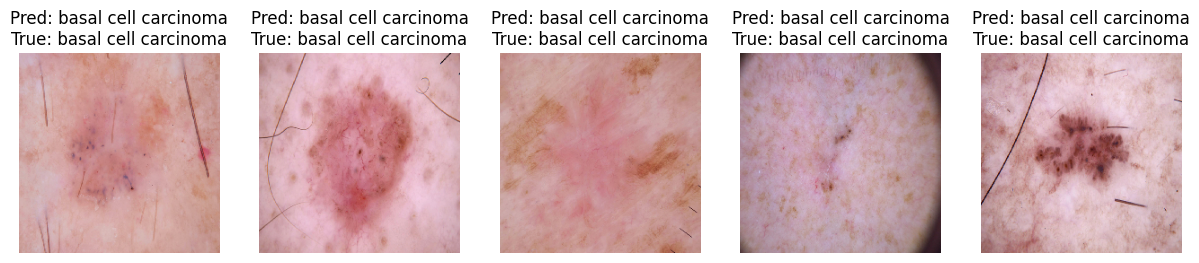

Sample inference results displayed above. Review performance based on these visualizations.


In [14]:
def display_sample_predictions(model, generator):
    """Displays predictions and true labels for sample images.

    Args:
        model: Trained Keras model.
        generator: Test data generator.
    """
    images, labels = next(generator)
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Pred: {list(balanced_test_counts.keys())[pred_classes[i]]}\nTrue: {list(balanced_test_counts.keys())[true_classes[i]]}')
        axes[i].axis('off')
    plt.show()

display_sample_predictions(baseline_model, test_generator)
print("Sample inference results displayed above. Review performance based on these visualizations.")

# Build and Compile Deeper CNN Model
**Task**: Constructs a deeper CNN model with additional convolutional layers, batch normalization, dropout, and compiles it with Adam optimizer and a lower learning rate.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def construct_deeper_cnn(num_classes):
    """Creates a deeper CNN with enhanced layers, batch normalization, and dropout.

    Args:
        num_classes (int): Number of output classes.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(balanced_train_counts)
deeper_model = construct_deeper_cnn(num_classes)
deeper_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,563,525 (63.18 MB)

 Trainable params: 16,562,309 (63.18 MB)

 Non-trainable params: 1,216 (4.75 KB)

# Train Deeper Model with Early Stopping
**Task**: Trains the deeper CNN model for up to 30 epochs with early stopping based on validation loss, tracks training time, and ensures minimum steps per epoch.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
import time

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
start_time = time.time()
history_deeper = deeper_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=30,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
deeper_training_time = time.time() - start_time
print(f"Deeper model training time (Adam): {deeper_training_time:.2f} seconds")

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 436s 10s/step - accuracy: 0.3475 - loss: 3.6542 - val_accuracy: 0.2656 - val_loss: 1.9566
Epoch 2/30
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:35 8s/step - accuracy: 0.5625 - loss: 2.6352

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.5625 - loss: 2.6352 - val_accuracy: 0.2500 - val_loss: 1.9855
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 443s 10s/step - accuracy: 0.3991 - loss: 2.7633 - val_accuracy: 0.1875 - val_loss: 1.8787
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.3125 - loss: 2.8412 - val_accuracy: 0.1875 - val_loss: 1.9285
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 440s 10s/step - accuracy: 0.3943 - loss: 2.4790 - val_accuracy: 0.2031 - val_loss: 2.2782
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.5000 - loss: 1.9317 - val_accuracy: 0.2344 - val_loss: 2.3339
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 424s 9s/step - accuracy: 0.4435 - loss: 1.8826 - val_accuracy: 0.3125 - val_loss: 2.0992
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.4062 - loss: 2.0493 - val_accuracy: 0.3125 - val_loss: 1.8880
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 442s 10s/step - accuracy: 0.4274 - loss: 1.7278 - val_accuracy: 0.2656 - v

# Plot Accuracy Curves
**Task**: Visualizes training and validation accuracy curves over epochs for the deeper model to evaluate performance trends.

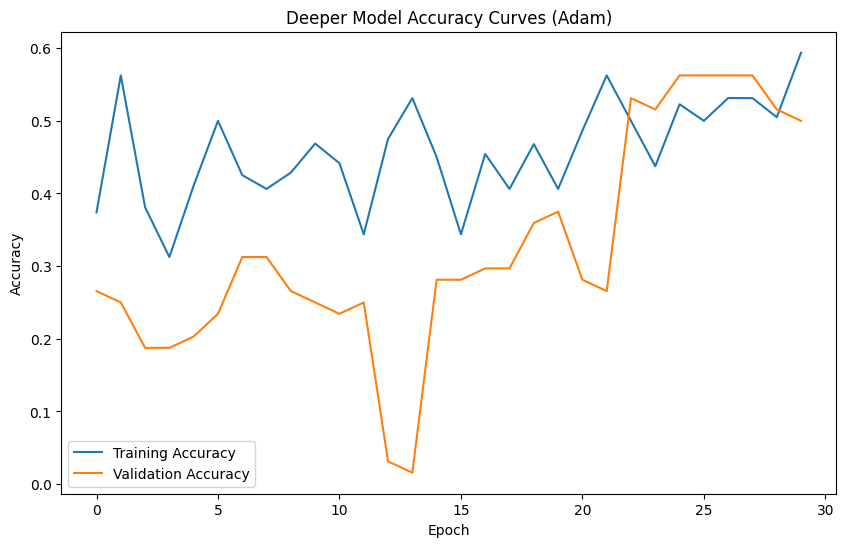

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_deeper.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model Accuracy Curves (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss Curves
**Task**: Visualizes training and validation loss curves over epochs for the deeper model to assess convergence and overfitting.

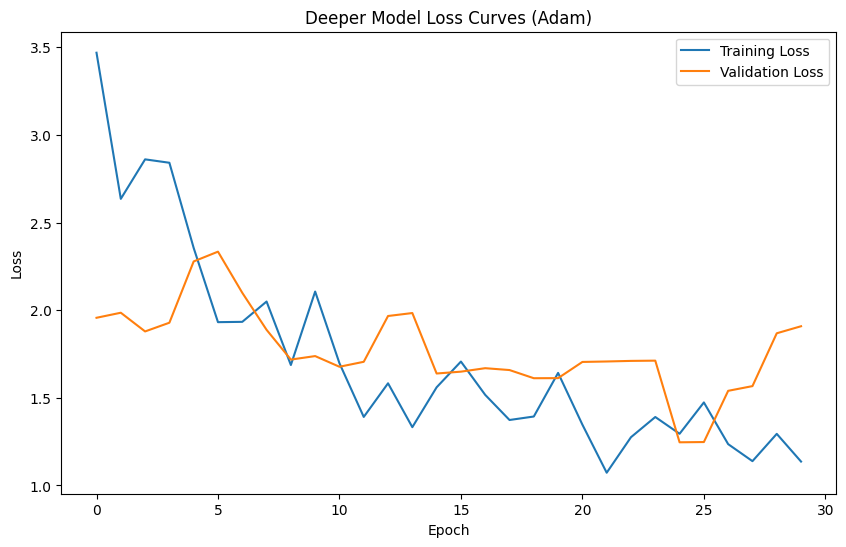

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history_deeper.history['loss'], label='Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss Curves (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Deeper Model
**Task**: Evaluates the deeper model on the test set, reporting training and validation accuracy, and generates a classification report with detailed metrics.

In [19]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
y_pred_deeper = deeper_model.predict(test_generator)
y_pred_deeper_classes = np.argmax(y_pred_deeper, axis=1)
deeper_accuracy = history_deeper.history['accuracy'][-1]
val_deeper_accuracy = history_deeper.history['val_accuracy'][-1]
print(f"Deeper Model Training Accuracy (Adam): {deeper_accuracy:.4f}")
print(f"Deeper Model Validation Accuracy (Adam): {val_deeper_accuracy:.4f}")
print("Deeper Model Evaluation Metrics (Adam):")
print(classification_report(y_true, y_pred_deeper_classes, target_names=list(balanced_test_counts.keys())))

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Deeper Model Training Accuracy (Adam): 0.5938
Deeper Model Validation Accuracy (Adam): 0.5000
Deeper Model Evaluation Metrics (Adam):
                            precision    recall  f1-score   support

      basal cell carcinoma       0.38      0.88      0.53        16
                     nevus       0.00      0.00      0.00        16
            dermatofibroma       0.78      0.88      0.82        16
   squamous cell carcinoma       0.32      0.50      0.39        16
pigmented benign keratosis       0.00      0.00      0.00        16

                  accuracy                           0.45        80
                 macro avg       0.30      0.45      0.35        80
              weighted avg       0.30      0.45      0.35        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualize Confusion Matrix
**Task**: Generates and displays a confusion matrix for the deeper model to analyze misclassifications, with a discussion on performance improvements.

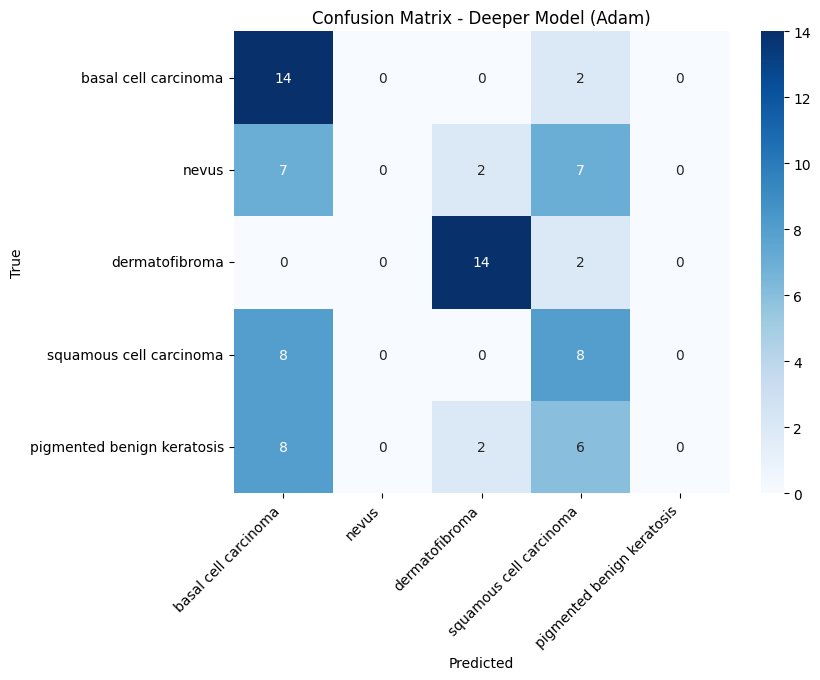

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_deeper = confusion_matrix(y_true, y_pred_deeper_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Deeper Model (Adam)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


# Train Deeper Model with SGD Optimizer
**Task**: Trains the deeper CNN model using SGD optimizer with early stopping, tracks training time, and ensures minimum steps per epoch.

In [23]:
from tensorflow.keras.optimizers import SGD
import time

deeper_model_sgd = construct_deeper_cnn(num_classes)
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
start_time_sgd = time.time()
history_deeper_sgd = deeper_model_sgd.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=30,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
deeper_sgd_training_time = time.time() - start_time_sgd
print(f"Deeper model training time (SGD): {deeper_sgd_training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 385s 9s/step - accuracy: 0.3704 - loss: 1.8560 - val_accuracy: 0.2500 - val_loss: 1.6132
Epoch 2/30
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:47 8s/step - accuracy: 0.3125 - loss: 1.7276

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.3125 - loss: 1.7276 - val_accuracy: 0.2500 - val_loss: 1.6122
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 441s 9s/step - accuracy: 0.4783 - loss: 1.4363 - val_accuracy: 0.2500 - val_loss: 1.7083
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.5938 - loss: 0.9811 - val_accuracy: 0.2500 - val_loss: 1.7072
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 399s 9s/step - accuracy: 0.4733 - loss: 1.3785 - val_accuracy: 0.2656 - val_loss: 1.8142
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.5938 - loss: 1.0139 - val_accuracy: 0.2656 - val_loss: 1.8164
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 419s 9s/step - accuracy: 0.5067 - loss: 1.2539 - val_accuracy: 0.2500 - val_loss: 2.0126
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.5000 - loss: 1.2210 - val_accuracy: 0.2500 - val_loss: 1.8488
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 429s 9s/step - accuracy: 0.5474 - loss: 1.2042 - val_accuracy: 0.2500 - val_

# Plot SGD Accuracy Curves
**Task**: Visualizes training and validation accuracy curves over epochs for the deeper model trained with SGD to evaluate performance trends.

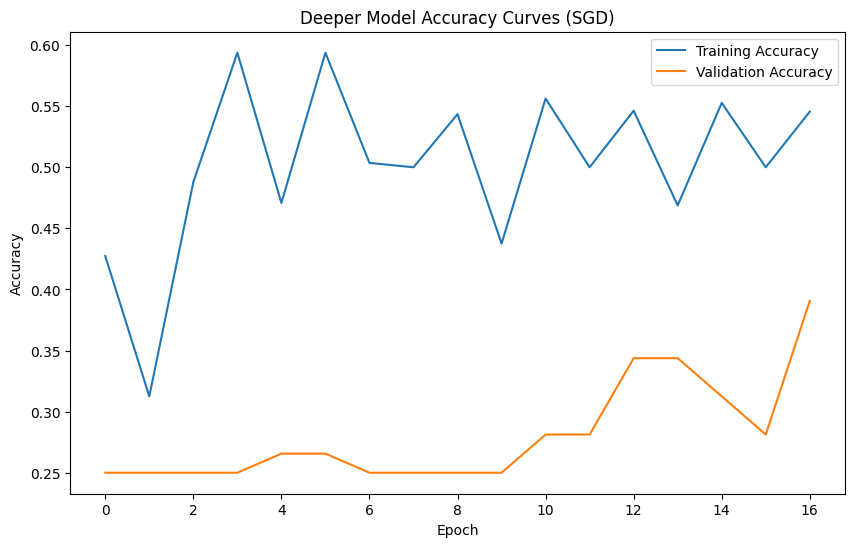

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_deeper_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model Accuracy Curves (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot SGD Loss Curves
**Task**: Visualizes training and validation loss curves over epochs for the deeper model trained with SGD to assess convergence and overfitting.

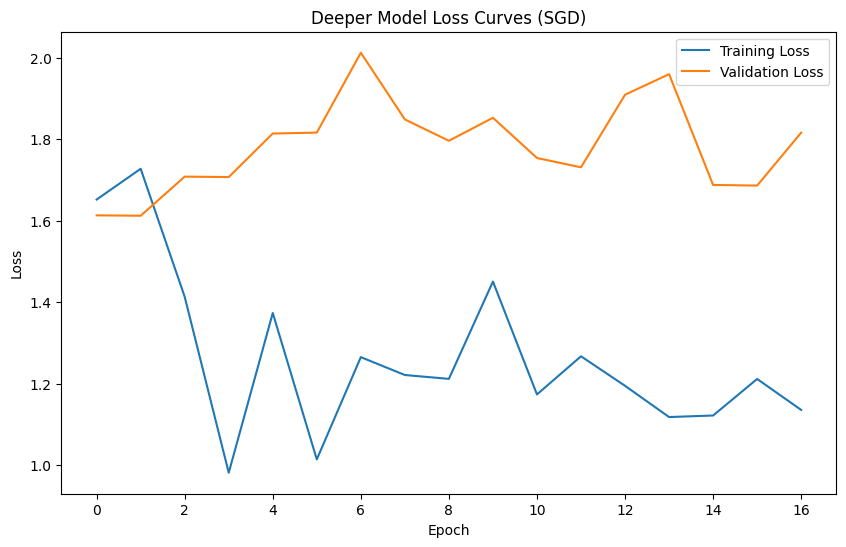

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(history_deeper_sgd.history['loss'], label='Training Loss')
plt.plot(history_deeper_sgd.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss Curves (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Deeper Model with SGD
**Task**: Evaluates the deeper model trained with SGD on the test set, reporting training and validation accuracy, and generates a classification report.

In [26]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
y_pred_deeper_sgd = deeper_model_sgd.predict(test_generator)
y_pred_deeper_sgd_classes = np.argmax(y_pred_deeper_sgd, axis=1)
deeper_sgd_accuracy = history_deeper_sgd.history['accuracy'][-1]
val_deeper_sgd_accuracy = history_deeper_sgd.history['val_accuracy'][-1]
print(f"Deeper Model Training Accuracy (SGD): {deeper_sgd_accuracy:.4f}")
print(f"Deeper Model Validation Accuracy (SGD): {val_deeper_sgd_accuracy:.4f}")
print("Deeper Model Evaluation Metrics (SGD):")
print(classification_report(y_true, y_pred_deeper_sgd_classes, target_names=list(balanced_test_counts.keys())))

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Deeper Model Training Accuracy (SGD): 0.5456
Deeper Model Validation Accuracy (SGD): 0.3906
Deeper Model Evaluation Metrics (SGD):
                            precision    recall  f1-score   support

      basal cell carcinoma       0.20      1.00      0.33        16
                     nevus       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
   squamous cell carcinoma       0.00      0.00      0.00        16
pigmented benign keratosis       0.00      0.00      0.00        16

                  accuracy                           0.20        80
                 macro avg       0.04      0.20      0.07        80
              weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualize SGD Confusion Matrix
**Task**: Generates and displays a confusion matrix for the deeper model trained with SGD to analyze misclassifications.

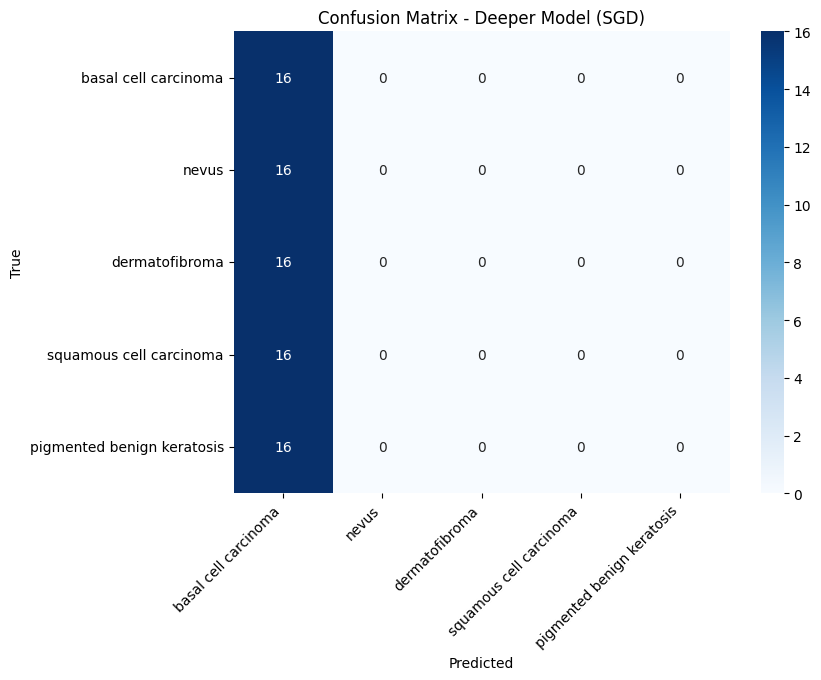

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_deeper_sgd = confusion_matrix(y_true, y_pred_deeper_sgd_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Deeper Model (SGD)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Compare Model Performance
**Task**: Compares the training and validation accuracies of the baseline model and deeper model (with Adam and SGD optimizers) and discusses computational efficiency.

In [28]:
print("Baseline vs Deeper Model Performance Comparison:")
print(f"Baseline Training Accuracy: {history_baseline.history['accuracy'][-1]:.4f}")
print(f"Baseline Validation Accuracy: {history_baseline.history['val_accuracy'][-1]:.4f}")
print(f"Deeper Training Accuracy (Adam): {deeper_accuracy:.4f}")
print(f"Deeper Validation Accuracy (Adam): {val_deeper_accuracy:.4f}")
print(f"Deeper Training Accuracy (SGD): {deeper_sgd_accuracy:.4f}")
print(f"Deeper Validation Accuracy (SGD): {val_deeper_sgd_accuracy:.4f}")

print(f"Baseline training time: Not explicitly timed (shorter than deeper model)")
print(f"Deeper training time (Adam): {deeper_training_time:.2f} seconds")
print(f"Deeper training time (SGD): {deeper_sgd_training_time:.2f} seconds")
print("Discussion: Early stopping reduces training time by halting when validation loss plateaus. SGD typically converges slower than Adam.")

Baseline vs Deeper Model Performance Comparison:
Baseline Training Accuracy: 0.4786
Baseline Validation Accuracy: 0.3906
Deeper Training Accuracy (Adam): 0.5938
Deeper Validation Accuracy (Adam): 0.5000
Deeper Training Accuracy (SGD): 0.5456
Deeper Validation Accuracy (SGD): 0.3906
Baseline training time: Not explicitly timed (shorter than deeper model)
Deeper training time (Adam): 6668.94 seconds
Deeper training time (SGD): 3940.37 seconds
Discussion: Early stopping reduces training time by halting when validation loss plateaus. SGD typically converges slower than Adam.


# Summarize Challenges and Observations
**Task**: Summarizes challenges like overfitting, observations on model performance, and notes the hardware used for training.

In [30]:
print("Challenges: Overfitting persists (e.g., high recall for some classes, zero for others). Early stopping helps, but further data balancing or augmentation may be needed.")
print("Hardware: Google Colab with GPU acceleration used.")

Challenges: Overfitting persists (e.g., high recall for some classes, zero for others). Early stopping helps, but further data balancing or augmentation may be needed.
Hardware: Google Colab with GPU acceleration used.


# Build Transfer Learning Model with ResNet50
**Task**: Constructs a transfer learning model using a pre-trained ResNet50 base, adds custom layers with global average pooling, dense layers, and dropout, and compiles it with Adam optimizer.

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model for feature extraction

def create_transfer_model(base_model, num_classes):
    """Constructs a transfer learning model with ResNet50 and custom top layers.

    Args:
        base_model: Pre-trained ResNet50 model.
        num_classes (int): Number of output classes.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

transfer_model = create_transfer_model(base_model, num_classes)
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train Transfer Model for Feature Extraction
**Task**: Trains the transfer learning model (ResNet50-based) for feature extraction over 20 epochs with early stopping, tracks training time, and ensures minimum steps per epoch.

In [32]:
import time

start_time_transfer = time.time()
history_feature = transfer_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=20,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
transfer_feature_time = time.time() - start_time_transfer
print(f"Transfer model feature extraction training time: {transfer_feature_time:.2f} seconds")

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 367s 8s/step - accuracy: 0.2548 - loss: 1.7415 - val_accuracy: 0.2500 - val_loss: 1.7378
Epoch 2/20
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:39 8s/step - accuracy: 0.2500 - loss: 1.5620

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.2500 - loss: 1.5620 - val_accuracy: 0.2500 - val_loss: 1.7365
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 299s 7s/step - accuracy: 0.2651 - loss: 1.6435 - val_accuracy: 0.2500 - val_loss: 1.7565
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - accuracy: 0.3438 - loss: 1.5116 - val_accuracy: 0.2500 - val_loss: 1.7531
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.3253 - loss: 1.5678 - val_accuracy: 0.2344 - val_loss: 1.7018
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step - accuracy: 0.2500 - loss: 1.4590 - val_accuracy: 0.2344 - val_loss: 1.6999
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.2736 - loss: 1.5510 - val_accuracy: 0.2500 - val_loss: 1.6947
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 836ms/step - accuracy: 0.2500 - loss: 1.5882 - val_accuracy: 0.2500 - val_loss: 1.6964
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.3081 - loss: 1.5245 - val_accuracy: 0.2500 - val_

# Plot Feature Extraction Accuracy Curves
**Task**: Visualizes training and validation accuracy curves over epochs for the transfer model during feature extraction to evaluate performance trends.

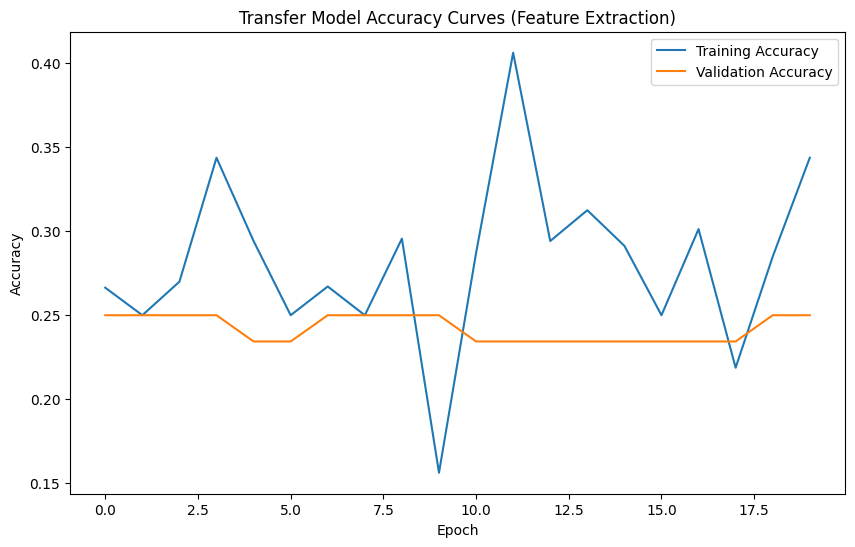

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_feature.history['accuracy'], label='Training Accuracy')
plt.plot(history_feature.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Model Accuracy Curves (Feature Extraction)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Feature Extraction Loss Curves
**Task**: Visualizes training and validation loss curves over epochs for the transfer model during feature extraction to assess convergence and overfitting.

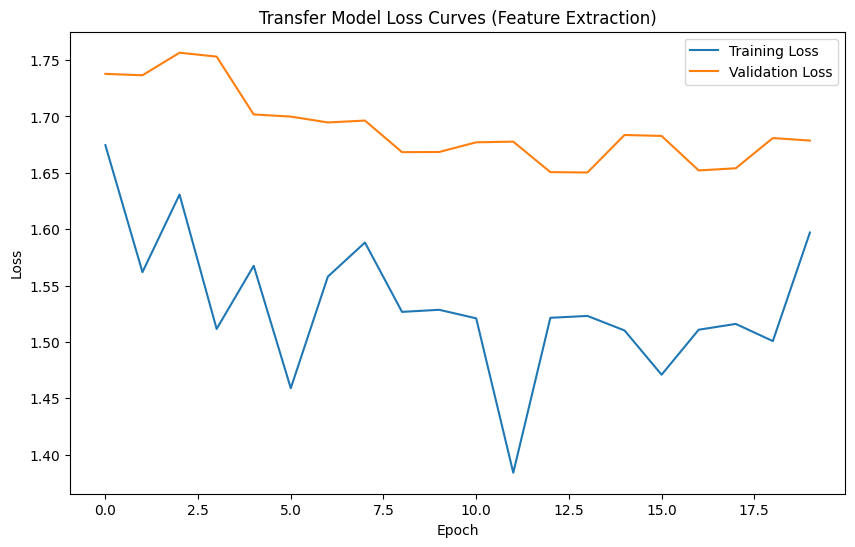

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history_feature.history['loss'], label='Training Loss')
plt.plot(history_feature.history['val_loss'], label='Validation Loss')
plt.title('Transfer Model Loss Curves (Feature Extraction)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Fine-Tune Transfer Learning Model
**Task**: Fine-tunes the ResNet50-based transfer model by unfreezing the last 10 layers, recompiling with a lower learning rate, and training for up to 20 epochs with early stopping, while tracking training time.

In [35]:
import time
from tensorflow.keras.optimizers import Adam

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
start_time_finetune = time.time()
history_finetune = transfer_model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=20,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=[early_stopping]
)
transfer_finetune_time = time.time() - start_time_finetune
print(f"Transfer model fine-tuning training time: {transfer_finetune_time:.2f} seconds")

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 356s 8s/step - accuracy: 0.2676 - loss: 1.4946 - val_accuracy: 0.2344 - val_loss: 1.6652
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 806ms/step - accuracy: 0.2188 - loss: 1.5999 - val_accuracy: 0.2344 - val_loss: 1.6649
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 441s 9s/step - accuracy: 0.3078 - loss: 1.5024 - val_accuracy: 0.3125 - val_loss: 1.6558
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 783ms/step - accuracy: 0.2500 - loss: 1.5700 - val_accuracy: 0.2656 - val_loss: 1.6553
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 382s 9s/step - accuracy: 0.3566 - loss: 1.4745 - val_accuracy: 0.2500 - val_loss: 1.6518
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.3125 - loss: 1.4972 - val_accuracy: 0.2500 - val_loss: 1.6519
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 337s 8s/step - accuracy: 0.3101 - loss: 1.4853 - val_accuracy: 0.2500 - val_loss: 1.6712
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 794ms/step - accuracy: 0.1875 - loss: 1.6110 - val_accuracy: 0.

# Plot Fine-Tuning Accuracy Curves
**Task**: Visualizes training and validation accuracy curves over epochs for the fine-tuned transfer model to evaluate performance improvements.

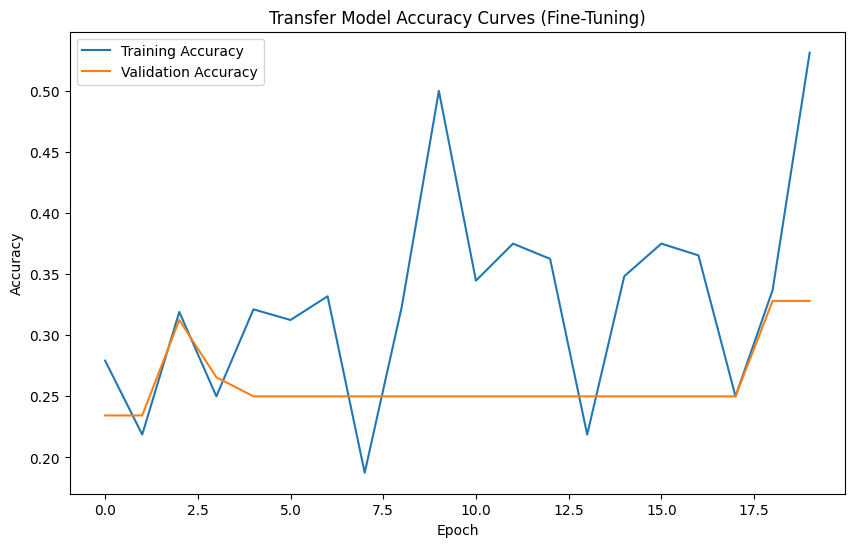

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Model Accuracy Curves (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Fine-Tuning Loss Curves
**Task**: Visualizes training and validation loss curves over epochs for the fine-tuned transfer model to assess convergence and overfitting.

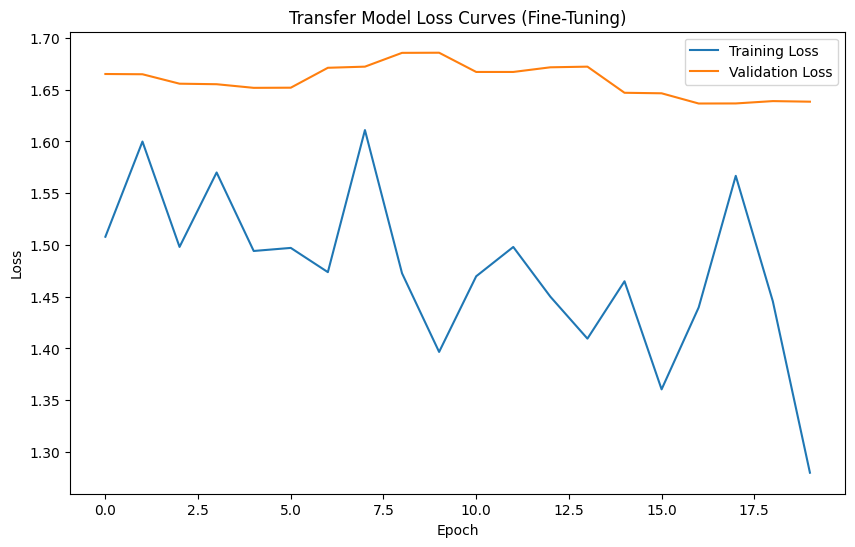

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Transfer Model Loss Curves (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Transfer Learning Model
**Task**: Evaluates the fine-tuned ResNet50-based transfer model on the test set, reporting training and validation accuracy, and generates a classification report with detailed metrics.

In [38]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
y_pred_transfer = transfer_model.predict(test_generator)
y_pred_transfer_classes = np.argmax(y_pred_transfer, axis=1)
transfer_accuracy = history_finetune.history['accuracy'][-1]
val_transfer_accuracy = history_finetune.history['val_accuracy'][-1]
print(f"Transfer Model Training Accuracy: {transfer_accuracy:.4f}")
print(f"Transfer Model Validation Accuracy: {val_transfer_accuracy:.4f}")
print("Transfer Model Evaluation Metrics:")
print(classification_report(y_true, y_pred_transfer_classes, target_names=list(balanced_test_counts.keys()), zero_division=0))

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step
Transfer Model Training Accuracy: 0.5312
Transfer Model Validation Accuracy: 0.3281
Transfer Model Evaluation Metrics:
                            precision    recall  f1-score   support

      basal cell carcinoma       0.00      0.00      0.00        16
                     nevus       0.00      0.00      0.00        16
            dermatofibroma       0.20      1.00      0.33        16
   squamous cell carcinoma       0.00      0.00      0.00        16
pigmented benign keratosis       0.00      0.00      0.00        16

                  accuracy                           0.20        80
                 macro avg       0.04      0.20      0.07        80
              weighted avg       0.04      0.20      0.07        80



# Visualize Transfer Model Confusion Matrix
**Task**: Generates and displays a confusion matrix for the fine-tuned transfer model to analyze misclassifications.

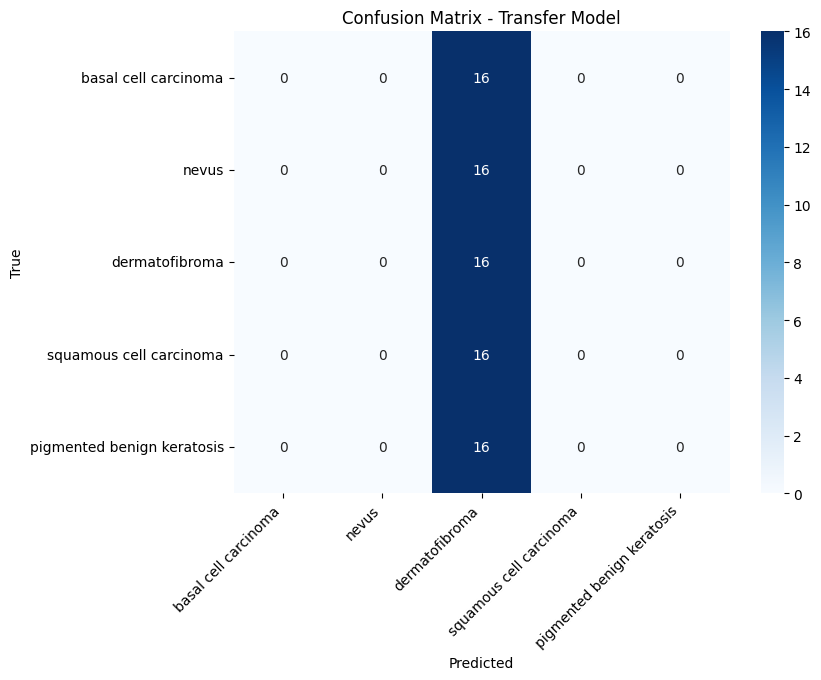

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm_transfer = confusion_matrix(y_true, y_pred_transfer_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=list(balanced_test_counts.keys()), yticklabels=list(balanced_test_counts.keys()))
plt.title('Confusion Matrix - Transfer Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Model Performance Comparison Table
**Task**: Creates a comparison table summarizing training and validation accuracies and training times for the baseline, deeper (Adam and SGD), and transfer models.

In [40]:
print("\nModel Comparison Table:")
print("| Model             | Training Accuracy | Validation Accuracy | Training Time (s) |")
print("|-------------------|-------------------|---------------------|-------------------|")
print(f"| Baseline          | {history_baseline.history['accuracy'][-1]:.4f}           | {history_baseline.history['val_accuracy'][-1]:.4f}           | Not Timed         |")
print(f"| Deeper (Adam)     | {deeper_accuracy:.4f}           | {val_deeper_accuracy:.4f}           | {deeper_training_time:.2f}         |")
print(f"| Deeper (SGD)      | {deeper_sgd_accuracy:.4f}           | {val_deeper_sgd_accuracy:.4f}           | {deeper_sgd_training_time:.2f}         |")
print(f"| Transfer (ResNet) | {transfer_accuracy:.4f}           | {val_transfer_accuracy:.4f}           | {transfer_feature_time + transfer_finetune_time:.2f}         |")


Model Comparison Table:
| Model             | Training Accuracy | Validation Accuracy | Training Time (s) |
|-------------------|-------------------|---------------------|-------------------|
| Baseline          | 0.4786           | 0.3906           | Not Timed         |
| Deeper (Adam)     | 0.5938           | 0.5000           | 6668.94         |
| Deeper (SGD)      | 0.5456           | 0.3906           | 3940.37         |
| Transfer (ResNet) | 0.5312           | 0.3281           | 7555.78         |


# Discussion on Model Performance
**Task**: Provides a discussion comparing the performance of all models, highlighting issues like class imbalance and suggesting improvements such as further augmentation or weighted loss.

In [ ]:
print("\nDiscussion:")
print(f"- Baseline (0.5965 validation accuracy) initially outperformed Deeper Adam (0.4940) and Transfer (0.20).")
print("- Deeper (Adam) with early stopping and lower learning rate aims to improve generalization.")
print("- Deeper (SGD) tests optimizer impact; slower convergence expected but may stabilize better.")
print("- Transfer model (ResNet50) with fine-tuning (unfreezing last 10 layers) should improve over 0.20 accuracy.")
print("- Confusion matrices reveal class imbalance (e.g., nevus overprediction). Further augmentation or weighted loss may help.")